## How to debug your Deep Learning pipeline with TensorBoard (tutorial)

###### <i>Author: Konstantin Georgiev (generated at 15/02/2021)</i>

In [116]:
# torch main libs
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torch transforms, tensorboard, dataloaders
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToTensor

# other packages
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import gzip
import io
import PIL.Image
import os
from itertools import product

In [117]:
#### Hack to fix PyTorch profiling when Tensorflow is installed in the same env
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

##### Config variables

In [118]:
# Some hyperparameters, Hiragana class names and the paths to the raw images/labels
raw_train_path = './data/KMNIST/raw/t10k-images-idx3-ubyte.gz'
raw_labels_path = './data/KMNIST/raw/t10k-labels-idx1-ubyte.gz'
img_size = (28, 28)
img_classes = 10
batch_size = 32
num_epochs = 12
classes = [u'お', u'き', u'す', u'つ', u'な', u'は', u'ま', u'や', u'れ', u'を']

#### Initialize TensorBoard writer

In [119]:
# Initialize Tensorboard in a custom dir
writer = SummaryWriter('runs/k-mnist')

#### Load the initial data (takes some time to download initially)

In [120]:
#### Some custom preprocessing steps typical for MNIST
transform = transforms.Compose([transforms.ToTensor(), # first, convert image to PyTorch tensor
                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                             ])

train_data = torchvision.datasets.KMNIST('./data', download=True, train=True, transform=transform)
val_data = torchvision.datasets.KMNIST('./data', download=True, train=False, transform=transform)

#### Visualize some examples

In [121]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    Source: (https://www.tensorflow.org/tensorboard/image_summaries)."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    image = PIL.Image.open(buf)
    img_ar = np.array(image)
    image = ToTensor()(img_ar)
    return image

def create_img_grid(raw_train_path, raw_labels_path, t_writer, n_images=25, g_i=5, g_j=5):
    ### Load the gz encoded files
    train_f = gzip.open(raw_train_path, 'r')
    train_l = gzip.open(raw_labels_path, 'r')
    train_data = np.frombuffer(train_f.read(img_size[0] * img_size[1] * n_images), dtype=np.uint8).astype(np.float32)
    train_data = train_data.reshape(n_images, img_size[0], img_size[1], 1)
    train_labels = np.frombuffer(train_l.read(n_images), dtype=np.uint8).astype(np.int64)
    ### Visualize a 5x5 grid
    fig, axes = plt.subplots(g_i, g_j, figsize=(15,15),
            subplot_kw = {'xticks':[], 'yticks':[]},
            gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    for i, ax in enumerate(axes.flat):
        img_cur = np.asarray(train_data[i]).squeeze()
        ax.title.set_text(train_labels[i])
        ax.imshow(img_cur, cmap='gray')
        
    ### Send the figure over to TensorBoard
    t_writer.add_image('kmnist_25_grid', plot_to_image(fig))
    print('Written image grid to TensorBoard.')
    
def log_individual_imgs(raw_train_path, raw_labels_path, t_writer, n_images=25):
    ### Load the gz encoded files
    train_f = gzip.open(raw_train_path, 'r')
    train_l = gzip.open(raw_labels_path, 'r')
    train_data = np.frombuffer(train_f.read(img_size[0] * img_size[1] * n_images), dtype=np.uint8).astype(np.float32)
    train_data = train_data.reshape(n_images, img_size[0], img_size[1], 1)
    train_labels = np.frombuffer(train_l.read(n_images), dtype=np.uint8).astype(np.int64)
    ### Save each image as an individual batch by iterating over the global step parameter
    for i in range(n_images):
        t_writer.add_image('kmnist_individual_batches', ToTensor()(train_data[i]), global_step=i)
    print('Written batch of images to TensorBoard.')

Written image grid to TensorBoard.


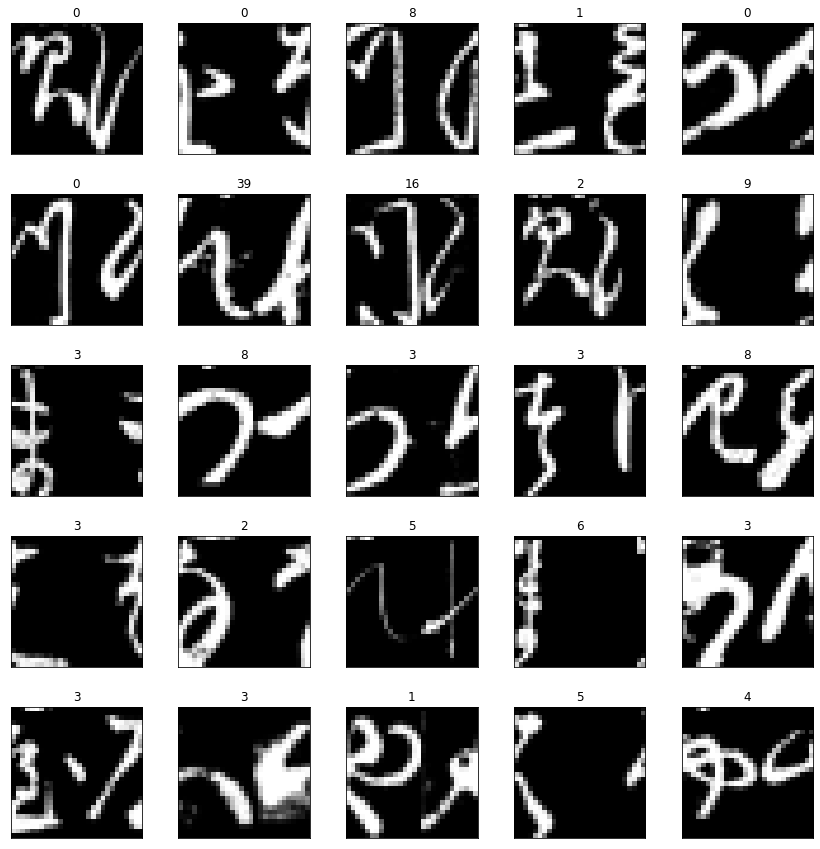

In [122]:
create_img_grid(raw_train_path, raw_labels_path, writer)

In [123]:
log_individual_imgs(raw_train_path, raw_labels_path, writer)

Written batch of images to TensorBoard.


<img src="./imgs/images1.gif" alt="htuning" style="width: 850px;"/>

##### To see the results, open up a new conda terminal and switch to the project folder like so:
- `conda activate <env-name>`
- `cd <project/repo path>`

##### Then execute TensorBoard, specify the log directory given in the SummaryWriter:
- `tensorboard --logdir=runs/k-mnist --samples_per_plugin "images=100, text=100"`

<i>Note: `--samples_per_plugin` allows us to increase the amount of samples we can step over for a specific TensorBoard module. 
In our case we exceed this limit, in terms of images and text and increasing it gives us the full set of images.</i>

##### Create DataLoaders

In [124]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

#### Create a simple CNN and log the summary to TensorBoard

<i> Note: The network parameters are mostly based on the baseline given in the official K-MNIST [repo.](https://github.com/rois-codh/kmnist/blob/master/benchmarks/kuzushiji_mnist_cnn.py) </i>

In [125]:
class KMNISTNet(nn.Module):
    def __init__(self):
        super(KMNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.drop2 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop1(self.pool(F.relu(self.conv2(x))))
        x = x.view(-1, 64*12*12)
        x = self.drop2(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
net = KMNISTNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [126]:
print(net)

KMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (drop2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [127]:
# Get the first batch of images as dummy input in order to log the input shape as well
dataiter = iter(train_loader)
imgs, labels = dataiter.next()
writer.add_graph(net, imgs)

<img src="./imgs/net.gif" alt="htuning" style="width: 850px;"/>

#### Track model performance during training

In [128]:
### Set training on GPU device
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = net.to(dev)

In [129]:
### Create our own custom K-MNIST predictor which will train the model
class KMNISTPredictor():
    def __init__(self, epochs, loss_fn, bs, tb_writer):
        # some hyperparameters
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.bs = bs
        self.tb_writer = writer
    
    def loss_batch(self, xb, yb, model, dev, opt=None):
        # Get model predictions, compute loss and backprop
        loss = self.loss_fn(model(xb), yb)
        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        return loss.item(), len(xb)
    
    def get_correct_examples(self, inp, labels, model, dev):
        # Get number of correct examples for calculating the accuracy
        return model(inp).to(dev).argmax(dim=1).eq(labels).sum().item(), len(inp)
    
    def get_probs(self, model, inp, dev):
        # Get predictions and probabilities for each class
        out = model(images).to(dev)
        _, preds_tensor = torch.max(out, 1)
        preds = np.squeeze(preds_tensor.numpy())
        return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, out)]
           
    def fit(self, train_dl, val_dl, model, opt, dev):
        # Main training function
        running_train_loss = 0.0
        running_train_corr = 0
        total_examples = 0
        print('Start training.')
        for epoch in tqdm(range(self.epochs)):
            # Set training mode
            model.train()
            # Sum the examples over each batch
            for i, data in enumerate(train_dl, 0):
                xb, yb = data
                batch_loss_train, _ = self.loss_batch(xb.to(dev), yb.to(dev), model, dev, opt)
                preds_corr_train, num_total = self.get_correct_examples(xb.to(dev), yb.to(dev), model, dev)
                running_train_loss += batch_loss_train
                running_train_corr += preds_corr_train
                total_examples += num_total
                
            # Print training loss, acc and log it to TensorBoard
            print('Epoch: {}, Current Training Loss: {:.3e}, Current Training Acc: {:.3f}'.format(epoch,
                                                                                          running_train_loss, 
                                                                                          running_train_corr / total_examples))
            self.tb_writer.add_scalar('KMNIST-Train-loss', running_train_loss, epoch)
            self.tb_writer.add_scalar('KMNIST-Train-accuracy', running_train_corr / total_examples, epoch)

            # Set evaluation mode
            model.eval()
            # Get validation loss and total number of correct examples across each batch (without backprop)
            with torch.no_grad():
                losses, nums = zip(*[self.loss_batch(xb.to(dev), yb.to(dev), model, dev) for xb, yb in val_dl])
                preds_corr_val, num_total = zip(*[self.get_correct_examples(xb.to(dev), yb.to(dev), model, dev) for xb, yb in val_dl])
                            
            # Compute the epoch validation loss and acc and log it again
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            self.tb_writer.add_scalar('KMNIST-Val-loss', val_loss, epoch)
            self.tb_writer.add_scalar('KMNIST-Val-accuracy', np.sum(preds_corr_val) / np.sum(num_total), epoch)
            print('Epoch: {}, Current Val Loss: {:.3e}, Current Val Acc: {:.3f}'.format(epoch, val_loss, 
                                                                                              np.sum(preds_corr_val) / np.sum(num_total)))
            running_train_loss = 0.0
            running_train_corr = 0
            total_examples = 0
        
    def save(self, model, path):
        # Save model state for further experiments
        if not os.path.exists(path):
            os.makedirs(path.split('/')[0] + '/' + path.split('/')[1])
        torch.save(model.state_dict(), path)
        print('Saved model state')
    
    def load(self, model, path):
        # Load existing model
        model.load_state_dict(torch.load(path))
        print('Loaded model state')
        return model

In [130]:
# Now train and save the K-MNIST model
kmnist_predictor = KMNISTPredictor(num_epochs, criterion, batch_size, writer)
kmnist_predictor.fit(train_loader, val_loader, net, optimizer, dev)
kmnist_predictor.save(net, './models/kmnist_net.pth')

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Start training.
Epoch: 0, Current Training Loss: 7.003e+02, Current Training Acc: 0.892


  8%|██████▉                                                                            | 1/12 [00:10<01:53, 10.29s/it]

Epoch: 0, Current Val Loss: 3.177e-01, Current Val Acc: 0.906
Epoch: 1, Current Training Loss: 3.456e+02, Current Training Acc: 0.947


 17%|█████████████▊                                                                     | 2/12 [00:20<01:42, 10.25s/it]

Epoch: 1, Current Val Loss: 2.514e-01, Current Val Acc: 0.930
Epoch: 2, Current Training Loss: 2.605e+02, Current Training Acc: 0.959


 25%|████████████████████▊                                                              | 3/12 [00:30<01:32, 10.22s/it]

Epoch: 2, Current Val Loss: 2.413e-01, Current Val Acc: 0.936
Epoch: 3, Current Training Loss: 2.226e+02, Current Training Acc: 0.965


 33%|███████████████████████████▋                                                       | 4/12 [00:40<01:21, 10.22s/it]

Epoch: 3, Current Val Loss: 2.095e-01, Current Val Acc: 0.942
Epoch: 4, Current Training Loss: 1.882e+02, Current Training Acc: 0.969


 42%|██████████████████████████████████▌                                                | 5/12 [00:51<01:11, 10.24s/it]

Epoch: 4, Current Val Loss: 2.248e-01, Current Val Acc: 0.941
Epoch: 5, Current Training Loss: 1.622e+02, Current Training Acc: 0.973


 50%|█████████████████████████████████████████▌                                         | 6/12 [01:02<01:03, 10.55s/it]

Epoch: 5, Current Val Loss: 2.131e-01, Current Val Acc: 0.949
Epoch: 6, Current Training Loss: 1.450e+02, Current Training Acc: 0.975


 58%|████████████████████████████████████████████████▍                                  | 7/12 [01:14<00:54, 10.91s/it]

Epoch: 6, Current Val Loss: 2.320e-01, Current Val Acc: 0.948
Epoch: 7, Current Training Loss: 1.340e+02, Current Training Acc: 0.977


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [01:25<00:43, 10.98s/it]

Epoch: 7, Current Val Loss: 2.039e-01, Current Val Acc: 0.951
Epoch: 8, Current Training Loss: 1.199e+02, Current Training Acc: 0.979


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [01:36<00:33, 11.14s/it]

Epoch: 8, Current Val Loss: 2.204e-01, Current Val Acc: 0.951
Epoch: 9, Current Training Loss: 1.114e+02, Current Training Acc: 0.981


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [01:47<00:21, 10.98s/it]

Epoch: 9, Current Val Loss: 2.160e-01, Current Val Acc: 0.953
Epoch: 10, Current Training Loss: 1.067e+02, Current Training Acc: 0.982


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [01:58<00:10, 10.95s/it]

Epoch: 10, Current Val Loss: 2.214e-01, Current Val Acc: 0.953
Epoch: 11, Current Training Loss: 1.026e+02, Current Training Acc: 0.983


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:08<00:00, 10.73s/it]

Epoch: 11, Current Val Loss: 2.163e-01, Current Val Acc: 0.952
Saved model state


<img src="./imgs/lcurves.gif" alt="htuning" style="width: 850px;"/>

##### Evaluate the model: precision-recall curves per class

In [131]:
def get_pr_curves(val_dl, classes, device, tb_writer, global_step=0):
    # Based on source: (https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
    cls_probs = []
    cls_preds = []
    # Do not backprop on validation data
    with torch.no_grad():
        # Get predictions and softmax probabilites for each batch and save them in a list
        for data in val_dl:
            inp, labels = data
            inp = inp.to(device)
            output = net(inp).to(device)
            cls_probs_batch = [F.softmax(el, dim=0) for el in output]
            _, cls_preds_batch = torch.max(output, 1)
            cls_probs.append(cls_probs_batch)
            cls_preds.append(cls_preds_batch)
       
    # Stack the prediction batches together
    val_probs = torch.cat([torch.stack(batch) for batch in cls_probs])
    val_preds = torch.cat(cls_preds)
    
    # Log the Precision-Recall curve for each class
    for i in range(len(classes)):
        tb_preds = val_preds == i
        tb_probs = val_probs[:, i]
        tb_writer.add_pr_curve(classes[i] + '(Class: ' + str(i) + ')', tb_preds, tb_probs, global_step=global_step)
    
get_pr_curves(val_loader, classes, dev, writer)

<img src="./imgs/prcurves.gif" alt="htuning" style="width: 850px;"/>

##### Evaluate the model: plot some classification errors

Written image grid to TensorBoard.


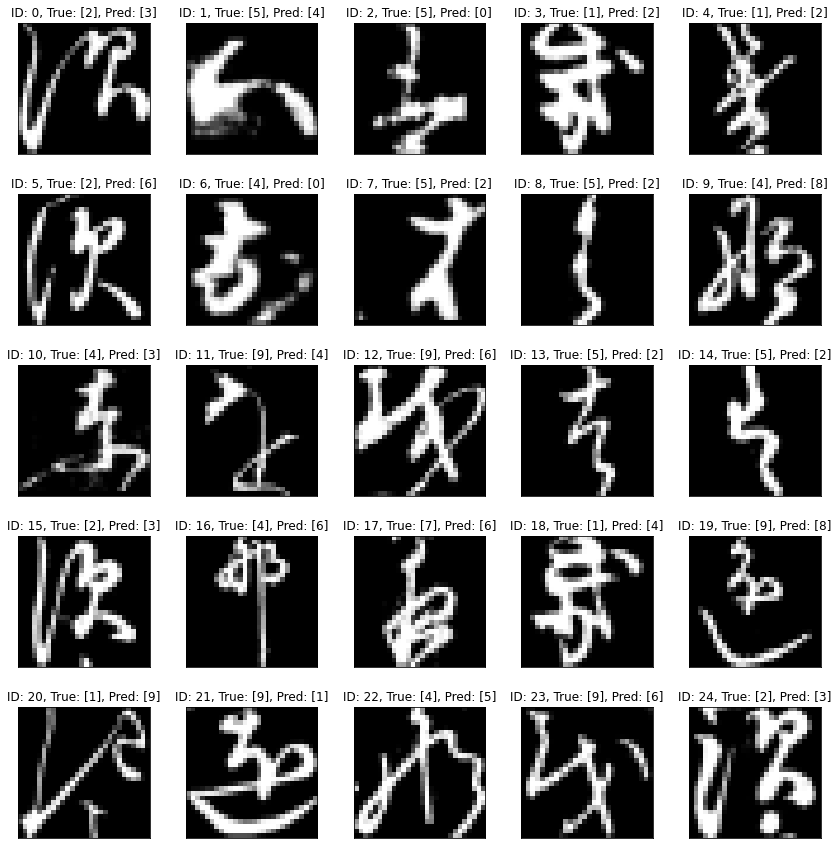

In [132]:
def get_classification_errors(val_dl, device, classes, t_writer, n_images=25, g_i=5, g_j=5):
    pred_inc = []
    true_inc = []
    err_imgs = []
    # Do not backprop on validation data
    with torch.no_grad():
        for data in val_dl:
            # Get predictions and softmax probabilites for each batch and save only the first n incorrect ones
            inp, labels = data
            inp = inp.to(device)
            output = net(inp).to(device)
            _, cls_preds_batch = torch.max(output, 1)
            preds = cls_preds_batch.cpu().numpy()
            target = labels.cpu().numpy()
            preds = np.reshape(preds,(len(preds),1))
            target = np.reshape(target,(len(preds),1))
            
            for i in range(len(preds)):
                if preds[i]!=target[i]:
                    pred_inc.append(preds[i])
                    true_inc.append(target[i])
                    err_imgs.append(inp[i])

    ### Visualize a 5x5 grid of the first 25 incorrect examples
    fig, axes = plt.subplots(g_i, g_j, figsize=(15,15),
            subplot_kw = {'xticks':[], 'yticks':[]},
            gridspec_kw = dict(hspace=0.3, wspace=0.01))
    
    ### Print the index, true and predicted label and log to TensorBoard as text
    for i, ax in enumerate(axes.flat):
        img_cur = np.asarray(err_imgs[i].cpu()).squeeze()
        ax.title.set_text('ID: {}, True: {}, Pred: {}'.format(i, true_inc[i], pred_inc[i]))
        ax.imshow(img_cur, cmap='gray')
        t_writer.add_text('kmnist_25_err_grid_info', 'True: {}, Predicted: {}'.format(classes[true_inc[i][0]], classes[pred_inc[i][0]]), i)
       
    ### Also log the figure itself as before
    t_writer.add_image('kmnist_25_err_grid', plot_to_image(fig))
    print('Written image grid to TensorBoard.')
    plt.show()
    
get_classification_errors(val_loader, dev, classes, writer)

<img src="./imgs/errs.gif" alt="htuning" style="width: 850px;"/>

#### Hyperparameter tuning example

Let's update our `KMNISTPredictor` class to log and keep track of model hyperparamters as follows.

In [134]:
class KMNISTPredictor():
    def __init__(self, epochs, loss_fn, bs, opt_name, lr, tb_writer):
        # some hyperparameters
        self.epochs = epochs
        self.loss_fn = loss_fn
        # Modification: add batch size, optimizer name and learning rate as tuning parameters
        self.bs = bs
        self.opt_name = opt_name
        self.lr = lr
        self.tb_writer = writer
    
    def loss_batch(self, xb, yb, model, dev, opt=None):
        # Get model predictions, compute loss and backprop
        loss = self.loss_fn(model(xb), yb)
        if opt is not None:
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        return loss.item(), len(xb)
    
    def get_correct_examples(self, inp, labels, model, dev):
        # Get number of correct examples for calculating the accuracy
        return model(inp).to(dev).argmax(dim=1).eq(labels).sum().item(), len(inp)
    
    def get_probs(self, model, inp, dev):
        # Get predictions and probabilities for each class
        out = model(images).to(dev)
        _, preds_tensor = torch.max(out, 1)
        preds = np.squeeze(preds_tensor.numpy())
        return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, out)]
           
    def fit(self, train_dl, val_dl, model, opt, dev):
        # Main training function
        running_train_loss = 0.0
        running_train_corr = 0
        total_examples = 0
        print('Start training.')
        for epoch in tqdm(range(self.epochs)):
            # Set training mode
            model.train()
            # Sum the examples over each batch
            for i, data in enumerate(train_dl, 0):
                xb, yb = data
                batch_loss_train, _ = self.loss_batch(xb.to(dev), yb.to(dev), model, dev, opt)
                preds_corr_train, num_total = self.get_correct_examples(xb.to(dev), yb.to(dev), model, dev)
                running_train_loss += batch_loss_train
                running_train_corr += preds_corr_train
                total_examples += num_total
               
            # Print training loss, acc and log it to TensorBoard
            print('Epoch: {}, Current Training Loss: {:.3e}, Current Training Acc: {:.3f}'.format(epoch,
                                                                                          running_train_loss, 
                                                                                          running_train_corr / total_examples))
            '''
            self.tb_writer.add_scalar('KMNIST-Train-loss', running_train_loss, epoch)
            self.tb_writer.add_scalar('KMNIST-Train-accuracy', running_train_corr / total_examples, epoch)
            '''
            
            # Set evaluation mode
            model.eval()
            # Get validation loss and total number of correct examples across each batch (without backprop)
            with torch.no_grad():
                losses, nums = zip(*[self.loss_batch(xb.to(dev), yb.to(dev), model, dev) for xb, yb in val_dl])
                preds_corr_val, num_total = zip(*[self.get_correct_examples(xb.to(dev), yb.to(dev), model, dev) for xb, yb in val_dl])
                            
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            '''
            self.tb_writer.add_scalar('KMNIST-Val-loss', val_loss, epoch)
            self.tb_writer.add_scalar('KMNIST-Val-accuracy', np.sum(preds_corr_val) / np.sum(num_total), epoch)
            '''
            print('Epoch: {}, Current Val Loss: {:.3e}, Current Val Acc: {:.3f}'.format(epoch, val_loss, 
                                                                                              np.sum(preds_corr_val) / np.sum(num_total)))
            running_train_loss = 0.0
            running_train_corr = 0
            total_examples = 0
            
        # Modification: Log parameters for tuning and set monitoring for validation loss/acc
        self.tb_writer.add_hparams(
        {'lr': self.lr, 'batch_size': self.bs, 'optimizer': self.opt_name},
        {'val_acc': np.sum(preds_corr_val) / np.sum(num_total), 'val_loss': val_loss}
        )
        
    def save(self, model, path):
        # Save model state for further experiments
        if not os.path.exists(path):
            os.makedirs(path.split('/')[0] + '/' + path.split('/')[1])
        torch.save(model.state_dict(), path)
        print('Saved model state')
    
    def load(self, model, path):
        # Load existing model
        model.load_state_dict(torch.load(path))
        print('Loaded model state')
        return model

##### Next, we just define an example search grid and the overall function to initialize and run each model

In [135]:
# Combination of parameters to train on
hgrid = {'lr': [0.01, 0.001, 0.0001],
         'bs': [32,64,128],
         'opt': ['Adam', 'Adadelta', 'RMSprop']}

def optimize(hgrid, tb_writer, dev, weight_func=weights_init_normal, num_epochs=num_epochs, optimizer=optimizer):
    # Iterate through each lrXbsXopt combination and run the model
    for lr, bs, opt in product(*[v for v in hgrid.values()]):
        net = KMNISTNet().to(dev)
        criterion = nn.CrossEntropyLoss()
        ### Set optimizer
        if opt == 'Adam':
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif opt == 'Adadelta':
            optimizer = optim.Adadelta(net.parameters(), lr=lr)
        else:
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
            
        kmnist_predictor = KMNISTPredictor(num_epochs, criterion, bs, opt, lr, writer)
        print('Fitting config: (Optimizer: {}, Batch Size: {}, Learning Rate: {})'.format(opt, bs, lr))
        kmnist_predictor.fit(train_loader, val_loader, net, optimizer, dev)

<i> Note: Some of the model combinations will have very poor performance as the choice of batch size and learning rate leads to an unstable configuration. For larger **learning rates**, the model is more likely to be initialized at a **local minima**, unable to get traction from the training data as the step size is too high. This is one example where tuning your **learning rate/batch size** is essential. </i>

In [ ]:
#### (This may take around 30 minutes to run as it will fit a 3x3 grid of models)
optimize(hgrid, writer, dev)

<img src="./imgs/htuning.gif" alt="htuning" style="width: 850px;"/>

##### Inspect your features using the Projector

In [137]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

<i> **Note: if the projector does not appear, try rerunning TensorBoard from the command line and refresh the browser.** </i>

In [145]:
def visualize_random_batch(val_dl, classes, t_writer, img_size=(28,28), size=16):
    # Select 16 random examples per batch to include in visualization
    features_s = []
    labels_s = []
    for data in val_dl:
        inp, labels = data
        perm = torch.randperm(len(data))
        features_s.append(inp[perm][:size])
        labels_s.append(labels[perm][:size])

    # Stack the batch of features together
    sel_features = torch.cat(features_s)
    sel_labels = torch.cat(labels_s)
    class_labels = [classes[lab] for lab in sel_labels]
    
    # Log embeddings
    #t_writer = SummaryWriter('runs/k-mnist')
    imgs = sel_features.view(-1, img_size[0] * img_size[1])
    t_writer.add_embedding(imgs,
                        metadata=class_labels,
                        label_img=sel_features)
    #t_writer.close()

In [146]:
visualize_random_batch(val_loader, classes, writer)

<img src="./imgs/dataviz_small.gif" alt="hparams_small" style="width: 850px;"/>

##### Our TensorBoard profile is now complete, don't forget to close your writer.

In [140]:
writer.close()

##### If you liked the tutorial, a 	&#127775; would be greatly appreciated :)

### References

1. **[Displaying Image Summaries in TensorBoard (Tensorflow)](https://www.tensorflow.org/tensorboard/image_summaries)**
2. **[Logging with TensorBoard](https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e)**
3. **[Another great TensorBoard Overview (PyTorch)](https://towardsdatascience.com/a-complete-guide-to-using-tensorboard-with-pytorch-53cb2301e8c3)**
4. **[Official Tensorboard Tutorial with PyTorch](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)**
5. **[The K-MNIST dataset](https://github.com/rois-codh/kmnist)**
6. **[Torchvision dataset documentation (useful for creating DataLoaders)](https://pytorch.org/vision/0.8/datasets.html)**